# 训推角色切换与权重更新

介绍： 在大模型的后训练过程中，推理作为强化学习（RL）的rollout环节，对整体效率有决定性影响。在训练与推理共用GPU的条件下，需要进行角色转换，并涉及同一张GPU上切换不同的rollout模型。因此，对推理框架提出了以下需求：

- 能够快速二次启动

- 在模型切换后能释放足够的显存

- 支持权重的在线更新

本例将主要分析推理框架的相关函数与功能，该过程**需要使用GPU**来完成数据采集。

相关文章：[RL训推共卡下框架(SGLang/vLLM)的切换效率分析](https://zhuanlan.zhihu.com/p/2002748926185469778)

Author: kaiyuan

Email: kyxie@zju.edu.cn

## 1 vLLM框架的睡眠模式与权重更新

案例思路：

- 自定义ModelLoader，以改变vLLM框架中权重的加载行为；

- 分别收集模型在sleep mode（卸载）与wake up（加载）状态下的显存使用信息；

- 当vLLM模型处于sleep mode时，使用PyTorch创建张量来模拟训练任务占用显存；

将记录的显存信息打印输出。

执行步骤：

- 创建LLM实例，并执行离线推理；

- 卸载该LLM的KV Cache和模型权重；

- 创建一个超大的Tensor，以模拟训练阶段占用显存；

- 卸载该超大Tensor，模拟训练任务结束；

- 重新加载LLM的权重与KV Cache；

- 再次触发LLM推理过程。

最后，观察并分析过程中的日志输出，打印并比对显存在各步骤中的变化情况。

### 1.1 GPU版运行代码



In [ ]:
# -*- coding: gbk -*-
import gc
import os

import pynvml
import torch
import torch.nn as nn

os.environ["VLLM_ENABLE_V1_MULTIPROCESSING"] = "0"

from vllm.model_executor.model_loader import register_model_loader

from vllm.config import ModelConfig
from vllm.config.load import LoadConfig
from vllm.model_executor.model_loader.base_loader import BaseModelLoader
from vllm.model_executor.model_loader.weight_utils import initialize_dummy_weights
from vllm import LLM, SamplingParams


@register_model_loader("my_loader")
class MyModelLoader(BaseModelLoader):
    """Model loader that will set model weights to random values."""
    load_count = 0

    def __init__(self, load_config: LoadConfig):
        super().__init__(load_config)
        if load_config.model_loader_extra_config:
            raise ValueError(
                f"Model loader extra config is not supported for "
                f"load format {load_config.load_format}"
            )

    def download_model(self, model_config: ModelConfig) -> None:
        pass  # Nothing to download

    def load_weights(self, model: nn.Module, model_config: ModelConfig) -> None:
        initialize_dummy_weights(model)
        MyModelLoader.load_count += 1
        print(f"==***== load_weights count: {MyModelLoader.load_count} ==***==")


def print_pytorch_mem():
    """打印GPU内存状态"""
    print("=" * 60)
    print("PyTorch CUDA 内存状态查询:")
    i = 0  # 仅打印0号卡

    name = torch.cuda.get_device_name(i)
    allocated = torch.cuda.memory_allocated(i) / 1024 ** 3
    reserved = torch.cuda.memory_reserved(i) / 1024 ** 3
    total = torch.cuda.get_device_properties(i).total_memory / 1024 ** 3

    print(f"GPU：{i} ({name}):")
    print(f"  已分配: {allocated:.2f} GB")
    print(f"  缓存保留: {reserved:.2f} GB")
    print(f"  总内存: {total:.2f} GB")
    print(f"  空闲内存: {total - allocated:.2f} GB")
    print("=" * 60)


class GPUMonitor:

    def __init__(self):
        """初始化时一次性建立连接"""
        pynvml.nvmlInit()
        self.handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        self._initialized = True
        self.history_used = []

    def print_memory(self, info=None, with_pytorch_print=True):
        mem = pynvml.nvmlDeviceGetMemoryInfo(self.handle)

        self.history_used.append((info, mem.used / 1024 ** 3))
        print(f"NVIDIA-SMI 状态： [GPU 0] 显存: {mem.used / 1024 ** 3:.1f}/{mem.total / 1024 ** 3:.1f} GB "
              f"({mem.used / mem.total * 100:.0f}%) Info：{info}")

        if with_pytorch_print:
            print_pytorch_mem()
        return mem.used, mem.total

    def __del__(self):
        """对象销毁时自动清理"""
        if getattr(self, '_initialized', False):
            try:
                pynvml.nvmlShutdown()
            except:
                pass


if __name__ == "__main__":
    monitor = GPUMonitor()
    monitor.print_memory("begin status", with_pytorch_print=False)
    model_name = "/data/kaiyuan/models/Qwen2.5-7B-Instruct"  # 替换为自己的模型
    llm = LLM(model=model_name,
              dtype='float16',
              load_format='my_loader',
              enable_sleep_mode=True)

    n = 16
    # 准备输入提示
    prompts = [
        "Hello, I'm kaiyuan",
        "Do you subscribe InfraTech?",
    ]

    # 设置采样参数
    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=50,
        n=n
    )

    outputs = llm.generate(prompts, sampling_params)
    monitor.print_memory("first generated")
    llm.sleep(level=2)
    monitor.print_memory("after sleep")

    # 用torch 尝试占用显存
    elements = int(20 * (1024 ** 3) / 4)
    big_tensor = torch.randn(elements, dtype=torch.float32, device='cuda')

    monitor.print_memory("created big tensor")
    del big_tensor
    gc.collect()
    torch.cuda.empty_cache()

    monitor.print_memory("deleted big tensor")
    # Reallocate weights memory only
    llm.wake_up(tags=["weights"])
    # Load weights in-place
    llm.collective_rpc("reload_weights")
    monitor.print_memory("weights reloaded.")
    # Reallocate KV cache
    llm.wake_up(tags=["kv_cache"])

    monitor.print_memory("kv cache waked up.")
    outputs = llm.generate(prompts, sampling_params)
    monitor.print_memory("second generated")
    print(monitor.history_used)


### 1.2 测试环境示例

测试机器信息：
- NVIDIA A100-SXM4-80GB
- NVIDIA-SMI 570.172.08
- Driver Version: 570.172.08
- CUDA Version: 13.1

镜像信息：
nvcr.io/nvidia/vllm:26.01-py3
- vllm  0.13.0+faa43dbf.nv26.1.cu131
- torch  2.10.0a0+a36e1d39eb.nvinternal.main.41386253

模型： Qwen2.5-7B-Instruct

输出：
```
INFO 02-05 03:53:02 [parallel_state.py:1203] world_size=1 rank=0 local_rank=0 distributed_init_method=tcp://172.17.0.2:48673 backend=nccl
INFO 02-05 03:53:02 [parallel_state.py:1411] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, PCP rank 0, TP rank 0, EP rank 0
INFO 02-05 03:53:03 [gpu_model_runner.py:3562] Starting to load model /data/kaiyuan/models/Qwen2.5-7B-Instruct...
INFO 02-05 03:53:03 [cuda.py:351] Using FLASH_ATTN attention backend out of potential backends: ('FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION')
==***== load_weights count: 1 ==***==
INFO 02-05 03:53:04 [gpu_model_runner.py:3659] Model loading took 14.2488 GiB memory and 0.551620 seconds
INFO 02-05 03:53:06 [decorators.py:432] Directly load AOT compilation from path /root/.cache/vllm/torch_aot_compile/50663218884ee581de277dbf39d790715d43c977b478e017b50eb26a5e3de171/rank_0_0/model
INFO 02-05 03:53:07 [backends.py:643] Using cache directory: /root/.cache/vllm/torch_compile_cache/e5467232e7/rank_0_0/backbone for vLLM's torch.compile
INFO 02-05 03:53:07 [backends.py:703] Dynamo bytecode transform time: 2.43 s
INFO 02-05 03:53:09 [backends.py:226] Directly load the compiled graph(s) for compile range (1, 8192) from the cache, took 0.818 s
INFO 02-05 03:53:09 [monitor.py:34] torch.compile takes 3.25 s in total
INFO 02-05 03:53:10 [gpu_worker.py:375] Available KV cache memory: 55.63 GiB
INFO 02-05 03:53:10 [kv_cache_utils.py:1291] GPU KV cache size: 1,041,632 tokens
INFO 02-05 03:53:10 [kv_cache_utils.py:1296] Maximum concurrency for 32,768 tokens per request: 31.79x
Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 29.02it/s]
Capturing CUDA graphs (decode, FULL): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 35.13it/s]
INFO 02-05 03:53:13 [gpu_model_runner.py:4587] Graph capturing finished in 3 secs, took 0.49 GiB
INFO 02-05 03:53:13 [core.py:259] init engine (profile, create kv cache, warmup model) took 9.19 seconds
INFO 02-05 03:53:13 [llm.py:360] Supported tasks: ('generate',)
Adding requests: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 239.80it/s]
Processed prompts: 100%|█████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.19it/s, est. speed input: 354.00 toks/s, output: 2359.96 toks/s]
NVIDIA-SMI 状态： [GPU 0] 显存: 73.2/80.0 GB (92%) Info：first generated
============================================================
PyTorch CUDA 内存状态查询:
GPU：0 (NVIDIA A100-SXM4-80GB):
  已分配: 69.96 GB
  缓存保留: 71.64 GB
  总内存: 79.25 GB
  空闲内存: 9.29 GB
============================================================
INFO 02-05 03:53:14 [block_pool.py:447] Successfully reset prefix cache
INFO 02-05 03:53:14 [cumem.py:239] CuMemAllocator: sleep freed 69.97 GiB memory in total, of which 0.00 GiB is backed up in CPU and the rest 69.97 GiB is discarded directly.
INFO 02-05 03:53:14 [gpu_worker.py:132] Sleep mode freed 71.40 GiB memory, 1.09 GiB memory is still in use.
INFO 02-05 03:53:14 [abstract.py:306] It took 0.053981 seconds to fall asleep.
NVIDIA-SMI 状态： [GPU 0] 显存: 1.8/80.0 GB (2%) Info：after sleep
============================================================
PyTorch CUDA 内存状态查询:
GPU：0 (NVIDIA A100-SXM4-80GB):
  已分配: 69.96 GB
  缓存保留: 70.21 GB
  总内存: 79.25 GB
  空闲内存: 9.29 GB
============================================================
NVIDIA-SMI 状态： [GPU 0] 显存: 21.8/80.0 GB (27%) Info：created big tensor
============================================================
PyTorch CUDA 内存状态查询:
GPU：0 (NVIDIA A100-SXM4-80GB):
  已分配: 89.96 GB
  缓存保留: 90.21 GB
  总内存: 79.25 GB
  空闲内存: -10.71 GB
============================================================
NVIDIA-SMI 状态： [GPU 0] 显存: 1.8/80.0 GB (2%) Info：deleted big tensor
============================================================
PyTorch CUDA 内存状态查询:
GPU：0 (NVIDIA A100-SXM4-80GB):
  已分配: 69.96 GB
  缓存保留: 70.21 GB
  总内存: 79.25 GB
  空闲内存: 9.29 GB
============================================================
INFO 02-05 03:53:15 [abstract.py:324] It took 0.132881 seconds to wake up tags ['weights'].
INFO 02-05 03:53:15 [gpu_model_runner.py:3756] Reloading weights inplace...
==***== load_weights count: 2 ==***==
NVIDIA-SMI 状态： [GPU 0] 显存: 16.1/80.0 GB (20%) Info：weights reloaded.
============================================================
PyTorch CUDA 内存状态查询:
GPU：0 (NVIDIA A100-SXM4-80GB):
  已分配: 69.96 GB
  缓存保留: 70.21 GB
  总内存: 79.25 GB
  空闲内存: 9.29 GB
============================================================
INFO 02-05 03:53:17 [abstract.py:324] It took 1.754354 seconds to wake up tags ['kv_cache'].
NVIDIA-SMI 状态： [GPU 0] 显存: 71.8/80.0 GB (90%) Info：kv cache waked up.
============================================================
PyTorch CUDA 内存状态查询:
GPU：0 (NVIDIA A100-SXM4-80GB):
  已分配: 69.96 GB
  缓存保留: 70.21 GB
  总内存: 79.25 GB
  空闲内存: 9.29 GB
============================================================
Adding requests: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1372.71it/s]
Processed prompts: 100%|█████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.82it/s, est. speed input: 358.75 toks/s, output: 2391.63 toks/s]
NVIDIA-SMI 状态： [GPU 0] 显存: 72.0/80.0 GB (90%) Info：second generated
============================================================
PyTorch CUDA 内存状态查询:
GPU：0 (NVIDIA A100-SXM4-80GB):
  已分配: 69.96 GB
  缓存保留: 70.44 GB
  总内存: 79.25 GB
  空闲内存: 9.29 GB
============================================================
[('begin status', 0.748291015625), ('first generated', 73.23541259765625), ('after sleep', 1.83697509765625), ('created big tensor', 21.83697509765625), ('deleted big tensor', 1.83697509765625), ('weights reloaded.', 16.13970947265625), ('kv cache waked up.', 71.81158447265625), ('second generated', 72.03814697265625)]

```

## 1.3 打印显存的变化

数据绘图，打印上一步monitor.history_used保存的数据信息

数据示例：

```
[('begin status', 0.748291015625), ('first generated', 73.23541259765625), ('after sleep', 1.83697509765625), ('created big tensor', 21.83697509765625), ('deleted big tensor', 1.83697509765625), ('weights reloaded.', 16.13970947265625), ('kv cache waked up.', 71.81158447265625), ('second generated', 72.03814697265625)]

```

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

def plot_cuda_memory_usage(memory_data, title="NVIDIA CUDA Memory Used"):
    """
    Plot CUDA memory usage line chart with tuple input format.

    Parameters:
    memory_data : list of tuples [(str, float), ...]
        Memory usage data where each tuple contains:
        - str: X-axis label (e.g., timestamp, step name)
        - float: Y-axis value in GB
    title : str
        Chart title
    """

    if not memory_data:
        print("Warning: Empty data list provided")
        return

    if not isinstance(memory_data, list) or not all(isinstance(item, tuple) and len(item) == 2 for item in memory_data):
        raise TypeError("Input must be a list of tuples (str, float)")

    x_labels, y_values = zip(*memory_data)

    x_indices = list(range(len(x_labels)))

    y_min = min(y_values)
    y_max = max(y_values)
    y_range = y_max - y_min if y_max > y_min else 1.0

    fig, ax = plt.subplots(figsize=(14, 7), dpi=100)

    ax.plot(x_indices, y_values,
            marker='o',
            linestyle='-',
            linewidth=2.5,
            markersize=9,
            color='#2568C4',
            alpha=0.8,
            markerfacecolor='white',
            markeredgewidth=2,
            markeredgecolor='#2568C4')

    ax.fill_between(x_indices, y_values, alpha=0.1, color='#2568C4')

    for i, (x_label, y_value) in enumerate(memory_data):
        y_normalized = (y_value - y_min) / y_range

        if i > 0 and y_value < memory_data[i-1][1]:
            y_offset = -y_range * 0.08
            va = 'top'
            bbox_color = '#FFE8E8'
            border_color = '#D32F2F'
        else:
            y_offset = y_range * 0.08
            va = 'bottom'
            bbox_color = '#E8F5E9'
            border_color = '#2E7D32'

        text_y_pos = y_value + y_offset

        if text_y_pos < y_min + y_range * 0.05:
            text_y_pos = y_min + y_range * 0.1
            va = 'bottom'
        elif text_y_pos > y_max - y_range * 0.05:
            text_y_pos = y_max - y_range * 0.1
            va = 'top'

        ax.text(i, text_y_pos,
                f'{y_value:.2f} GB',
                ha='center',
                va=va,
                fontsize=10,
                fontweight='bold',
                color='black',
                bbox=dict(boxstyle='round,pad=0.3',
                         facecolor=bbox_color,
                         edgecolor=border_color,
                         alpha=0.9),
                zorder=10)

    ax.set_title(title, fontsize=18, fontweight='bold', pad=25)
    ax.set_xlabel('Time Instant', fontsize=14)
    ax.set_ylabel('Memory Usage (GB)', fontsize=14)

    ax.set_xticks(x_indices)
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=11)

    chart_bottom = y_min - y_range * 0.2 if y_min - y_range * 0.2 > 0 else 0
    chart_top = y_max + y_range * 0.4
    ax.set_ylim(chart_bottom, chart_top)

    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f GB'))

    ax.grid(True, alpha=0.2, linestyle='--', zorder=0)

    ax.tick_params(axis='both', which='major', labelsize=11)



    plt.subplots_adjust(bottom=0.2)

    plt.tight_layout()

    plt.show()

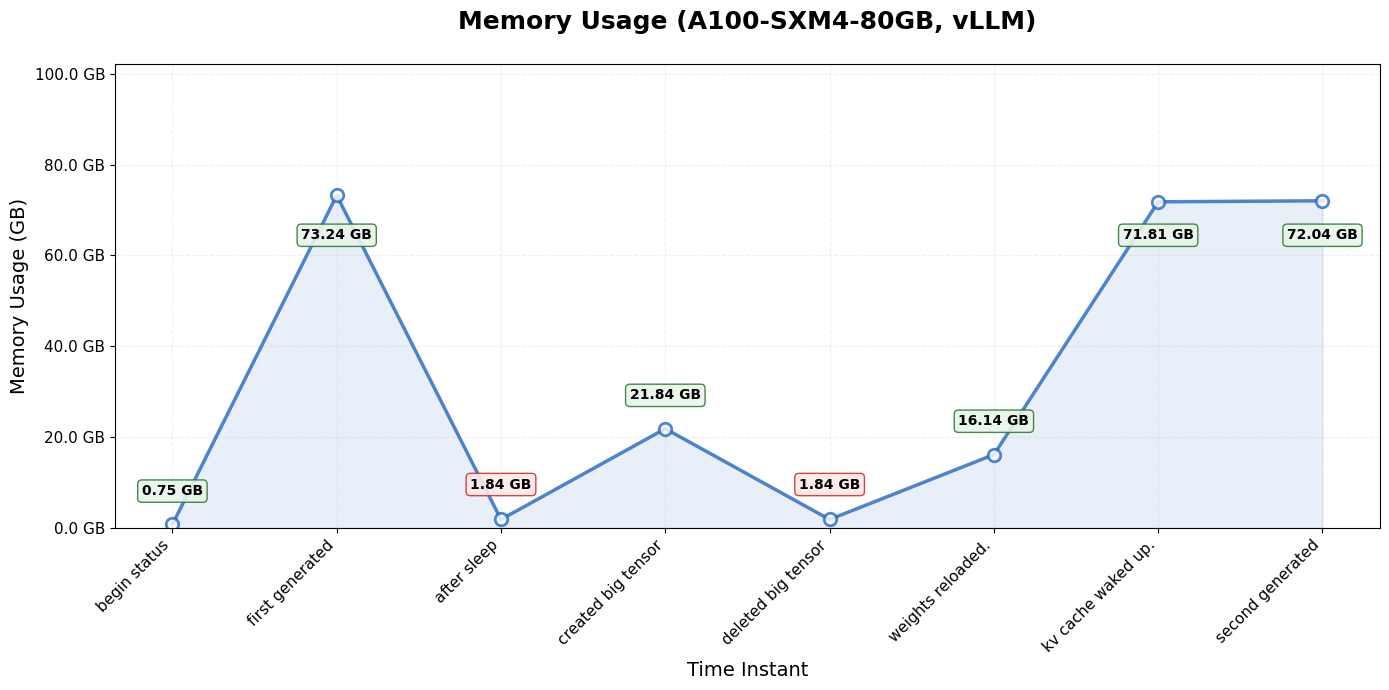

In [ ]:
memory_data = [('begin status', 0.748291015625), ('first generated', 73.23541259765625), ('after sleep', 1.83697509765625), ('created big tensor', 21.83697509765625), ('deleted big tensor', 1.83697509765625), ('weights reloaded.', 16.13970947265625), ('kv cache waked up.', 71.81158447265625), ('second generated', 72.03814697265625)]

# 使用不同样式绘制
plot_cuda_memory_usage(memory_data, "Memory Usage (A100-SXM4-80GB, vLLM)")

# 保存到文件
# plot_cuda_memory_advanced(memory_data, save_path="./memory_usage.png")